# Nonrigid alignment of Spateo alignment for 2D slices

Since sectioning experiments often introduce non-rigid deformations, it is crucial to consider the use of non-rigid transformation to align the slices to the coordinates of the reference slices. In this tutorial, we will introduce the how to perform the nonrigid alignment using Spateo and how to tune the degree of non-rigid deformation.

<div class="alert alert-info">

<strong>See also:</strong>

If you are interested in the mathematical details of our nonrigid transformation, please check our post:
[Spatial transcriptomics alignment](../../technicals/spatial_transcriptomics_alignment.md#Spatial_transcriptomics_alignment)

</div>

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda:3'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Running this notebook on:  cuda:3


2024-08-20 22:48:52.349707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 22:48:52.533954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-20 22:48:52.533979: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-20 22:48:53.241359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Last run with spateo version: 1.0.2.dev537+508dc2d.dirty


## Loading the Data

In this tutorial, we will use the slices from Adult mouse central nervous system, obtained using the STARMap Plus technique. According to the STARMmap Plus protocol, each slice has a three dimensional volume (the scale of the z-axis is much smaller than x,y-axis). This enables us to generate pseudo-slices with aligned spatial coordinates. You can download the processed data from the links below. Once downloaded, ensure you place the data in the appropriate directory.

- [Adult mouse central nervous system from STARMap Plus dataset sagittal #3](https://drive.google.com/file/d/1kaeBK1xEc-AuKNUPgBaYTKc7si_7WASW/view?usp=drive_link)

In [2]:
# Load the STARMap Plus slice
adata = st.read('./data/sagittal3.h5ad')

print(adata)
print(adata.obsm['spatial_raw'].shape)

AnnData object with n_obs × n_vars = 207591 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type'
    uns: 'Main_molecular_tissue_region_palette'
    obsm: 'spatial', 'spatial_raw'
(207591, 3)


## Visualize the STARMap Plus slice in 3D

<div class="alert alert-warning">
<strong>Warning:</strong>
    
The following code block involves pyvista. The Before you run the pyvista based visualization function "st.pl.three_d_plot", please check you have instailled pyvista correctly, especially for server. Otherwise, it may cause jupyter notebook to crash. We recommend the user to check the pyvista instailation tutorial. 
    
</div>

(EE) 
Fatal server error:
(EE) Server is already active for display 99
	If this server is no longer running, remove /tmp/.X99-lock
	and start again.
(EE) 


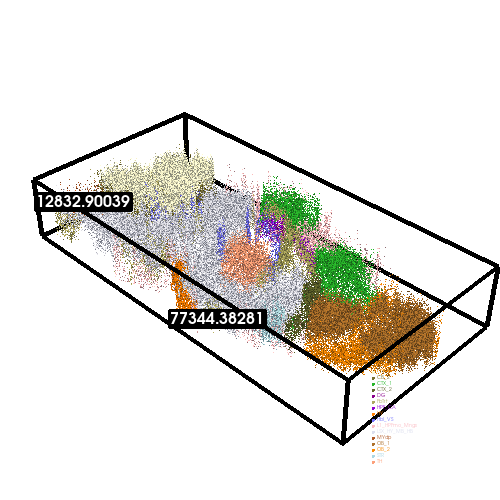

In [3]:
# Uncomment the following if running on the server
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

# define the palette
palette = adata.uns['Main_molecular_tissue_region_palette']

point_cloud, _ = st.tdr.construct_pc(adata=adata,spatial_key="spatial_raw",groupby="Main_molecular_tissue_region",key_added="tissue",colormap=palette,)

# make the z height bigger
point_cloud.points[:,2] *= 500

# show the STARMap Plus slice in 3D
st.pl.three_d_plot(
    model=point_cloud,
    key="tissue",
    model_style='points',
    model_size=1,
    jupyter="static",
    window_size=(500, 500),
    ambient=0.2,
    cpo='iso',
    show_outline=True,
)


## Cut pseudo slices

Next, we cut the STARMap Plus slice along the z-axis to generate four pseudo-slices. It's important to note that this strategy for generating pseudo-slices is not equivalent to random sampling, as the spatial distribution of the STARMap Plus slice along the z-axis will also vary.

In [4]:
import sys
sys.path.insert(0, "/home/ylu/project")
from utils import *

In [5]:
slices = st.align.split_slice(adata=adata,spatial_key='spatial_raw',split_num=8,axis=2,)
slices

[AnnData object with n_obs × n_vars = 25948 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
     uns: 'Main_molecular_tissue_region_palette'
     obsm: 'spatial', 'spatial_raw',
 AnnData object with n_obs × n_vars = 25948 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
     uns: 'Main_molecular_tissue_region_palette'
     obsm: 'spatial', 'spatial_raw',
 AnnData object with n_obs × n_vars = 25948 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
     uns: 'Main_molecular_tissue_region_palette'
     obsm: 'spatial', 'spatial_raw',
 AnnData object with n_obs × n_vars = 25948 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_ce

Despite having the same number of cells, the spatial distribution varies significantly from section to section.

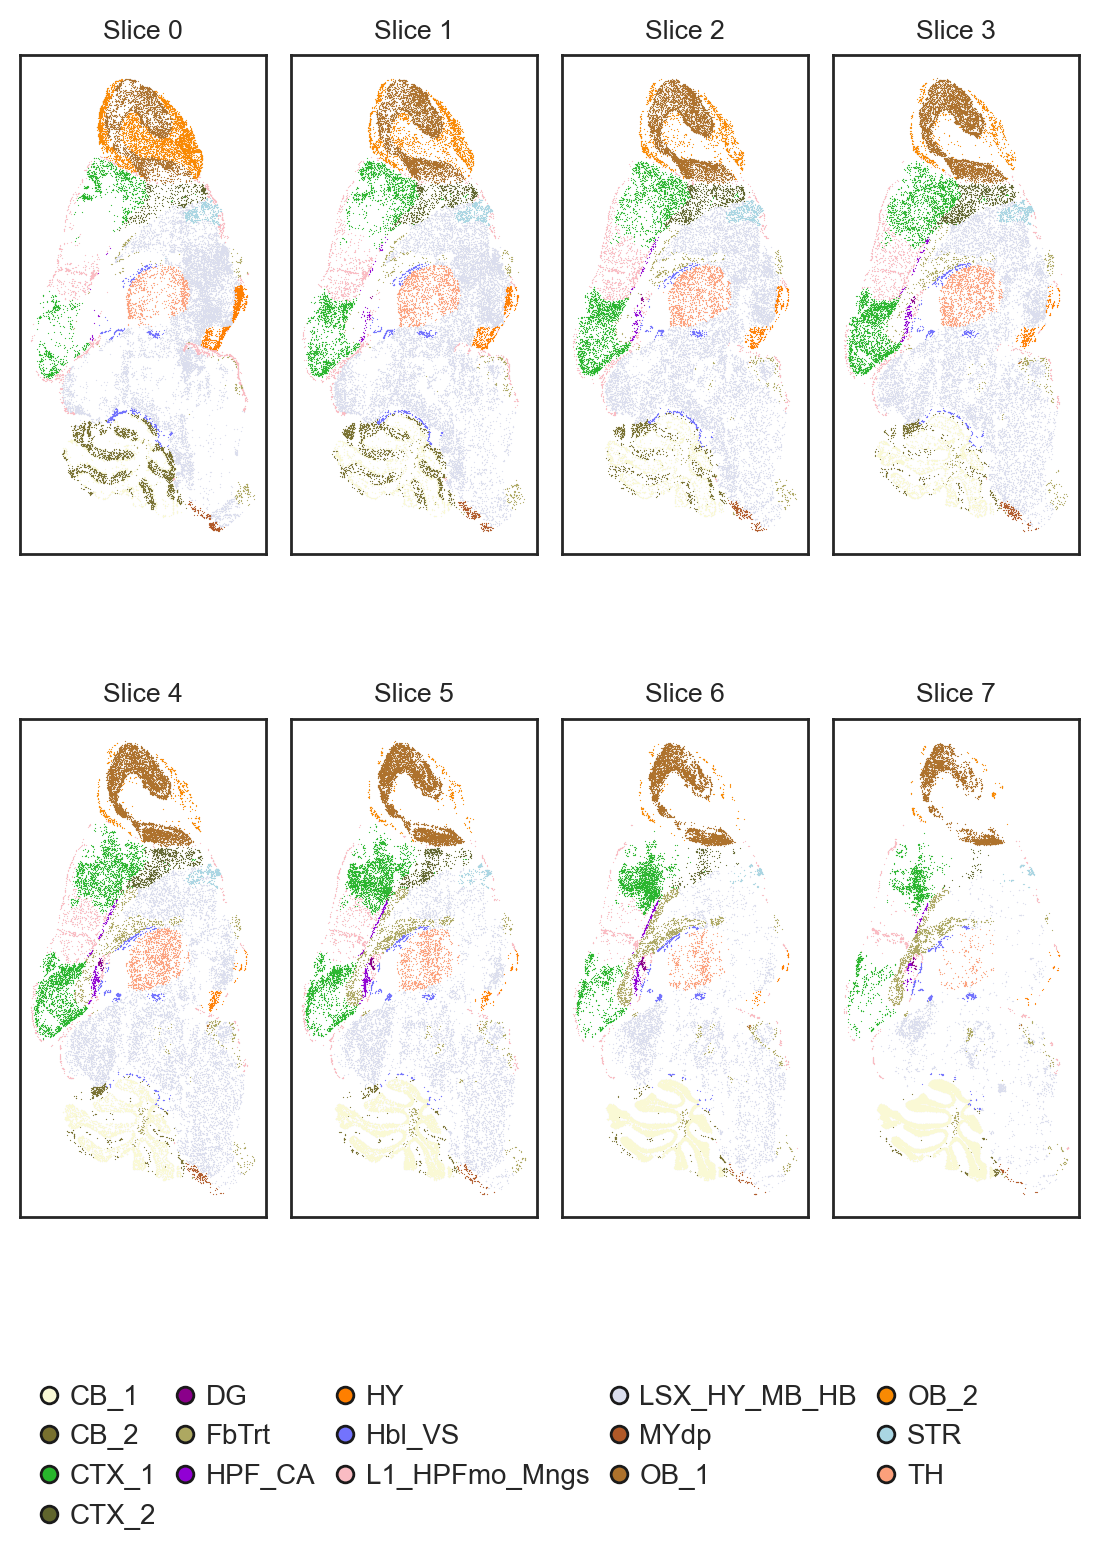

In [6]:
spatial_key = 'spatial_raw'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = slices,
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette=palette,
)

## Simulate nonrigid deformation using thin-plate-spine

To simulate non-rigid deformation, we use the thin-plate-spine or TPS algorithm (implemented from thin-plate-spine package). You can control the distortion level using the "tps_noise_scale" parameter. A higher value means the distortion is more significant, and vice verse. 

In [7]:
slice1 = slices[0].copy()
slice2 = slices[1].copy()
# tps_f = st.align.tps_deformation(
#     adata=slice2,
#     spatial_key='spatial',
#     key_added='tps_spatial',
#     tps_noise_scale=0.15,
# )
tps_f = tps_deformation(
    adata=slice2,
    spatial_key='spatial',
    key_added='tps_spatial',
    tps_noise_scale=0.15,
)
slice1.obsm['tps_spatial'] = slice1.obsm['spatial'].copy()

After the TPS algorithm, the spatial distribution of slice2 is significantly distorted.

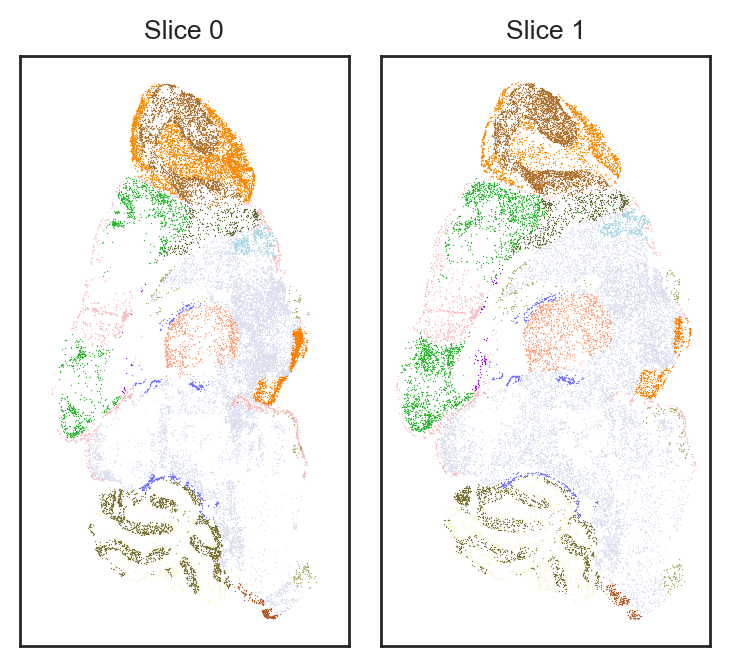

In [8]:
spatial_key = 'tps_spatial'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=False,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette=palette,
)

We can also plot the deformaiton grid to show the distortion.

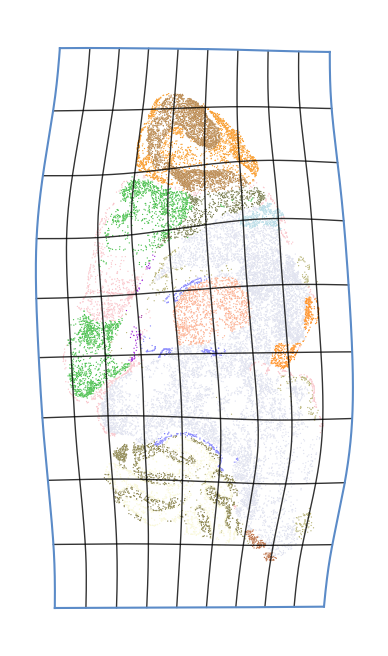

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_deformation_grid(
    slice2, 
    spatial_key,
    'spatial',
    cluster_key,
    tps_f,
    ax,
    0.2,
    grid_num=10,
    line_width=0.5,
    grid_color="black",
    expand_scale = 0.1,
    palette = palette,
    title = '',
    legend=True,
    fontsize=8,
    fill=False,
)
plt.show()

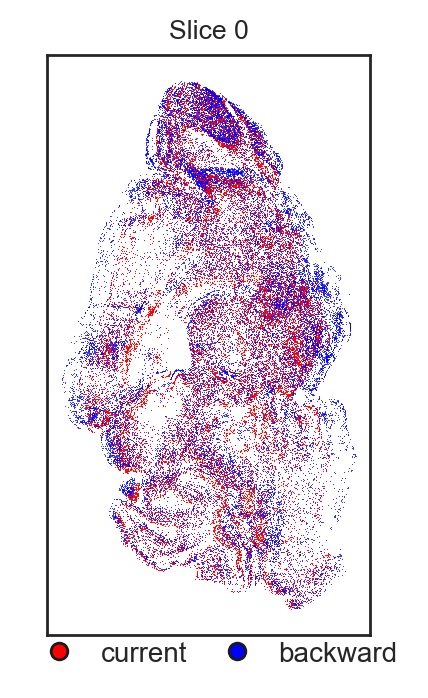

In [10]:
slice2_original = slice2.copy()
slice2_original.obsm['tps_spatial'] = slice2_original.obsm['spatial'].copy()
st.pl.overlay_slices_2d(slices = [slice2_original, slice2], spatial_key = 'tps_spatial', height=4, overlay_type='backward')

## Preprocessing

Next, we do some basic preprocessing.

In [11]:
# preprocess slice1
sc.pp.filter_cells(slice1, min_genes=10)  # we use min_genes=10 as 100 is too large for ST data
sc.pp.filter_genes(slice1, min_cells=3)
# Saving count data
slice1.layers["counts"] = slice1.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(slice1)
# Logarithmize the data
sc.pp.log1p(slice1)

# preprocess slice1
sc.pp.filter_cells(slice2, min_genes=10)
sc.pp.filter_genes(slice2, min_cells=3)
# Saving count data
slice2.layers["counts"] = slice2.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(slice2)
# Logarithmize the data
sc.pp.log1p(slice2)


adata_pca = ad.concat([slice1,slice2], label='batch')
sc.tl.pca(adata_pca)
slice1.obsm['X_pca'] = adata_pca[adata_pca.obs['batch'] == '0'].obsm['X_pca'].copy()
slice2.obsm['X_pca'] = adata_pca[adata_pca.obs['batch'] == '1'].obsm['X_pca'].copy()

## Spateo Nonrigid Alignment

Theoretically, three parameters control the degree of non-rigid deformation in Spateo. We describe each parameter below:

- **beta**: The length scale of the squared exponential (SE) kernel. A larger value means less correlation between points and more flexible non-rigid deformation, and vice versa. The default is `1e-2`. Recommended setting range: `[1e-4, 1e0]`.
- **lambdaVF**: The regularization parameter for the vector field of the non-rigid transformation. A smaller value means fewer constraints on non-rigid deformation, allowing for larger and more flexible deformations, and vice versa. The default is `1e2`. Recommended setting range: `[1e-1, 1e4]`.
- **K**: The number of sparse inducing points used for Nyström approximation of the kernel. A larger value allows for more complex relationships to be approximated, making the deformation more flexible, but it also increases computational overhead. The default is `15`. Recommended setting range: `[15, 500]`.

Typically, only the first two parameters require tuning. We next show the influence of different parameters settings.


In [12]:
beta_list = [1e-4, 1e-3, 1e-2, 1e-1, 1]
lambdaVF_list = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

# iterate all the parameters
aligned_slices = [slice1.copy(), slice2.copy()]
spatial_key = 'tps_spatial'
for beta in beta_list:
    for lambdaVF in lambdaVF_list:
        key_added = f"align_spatial_{beta}_{lambdaVF}"
        aligned_slices, pis = st.align.morpho_align(
            models=aligned_slices,
            spatial_key=spatial_key,
            key_added=key_added,
            device=device,
            beta=beta,
            lambdaVF=lambdaVF,
            verbose=False,
            rep_layer='X_pca',
            rep_field='obsm',
            dissimilarity='cos',
        )

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [7.2077s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [6.3926s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [6.2913s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [6.3102s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [6.1988s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [6.1783s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.000

We plot the overlay of the aligned slices with different values of beta. When `beta=1e-4`, the alignment behaves more like a rigid transformation, resulting in poorly aligned local structures. As beta increases, the nonrigid alignment becomes more flexible and achieves better alignment of local structures. The same trend applies to the parameter `lambdaVF`.


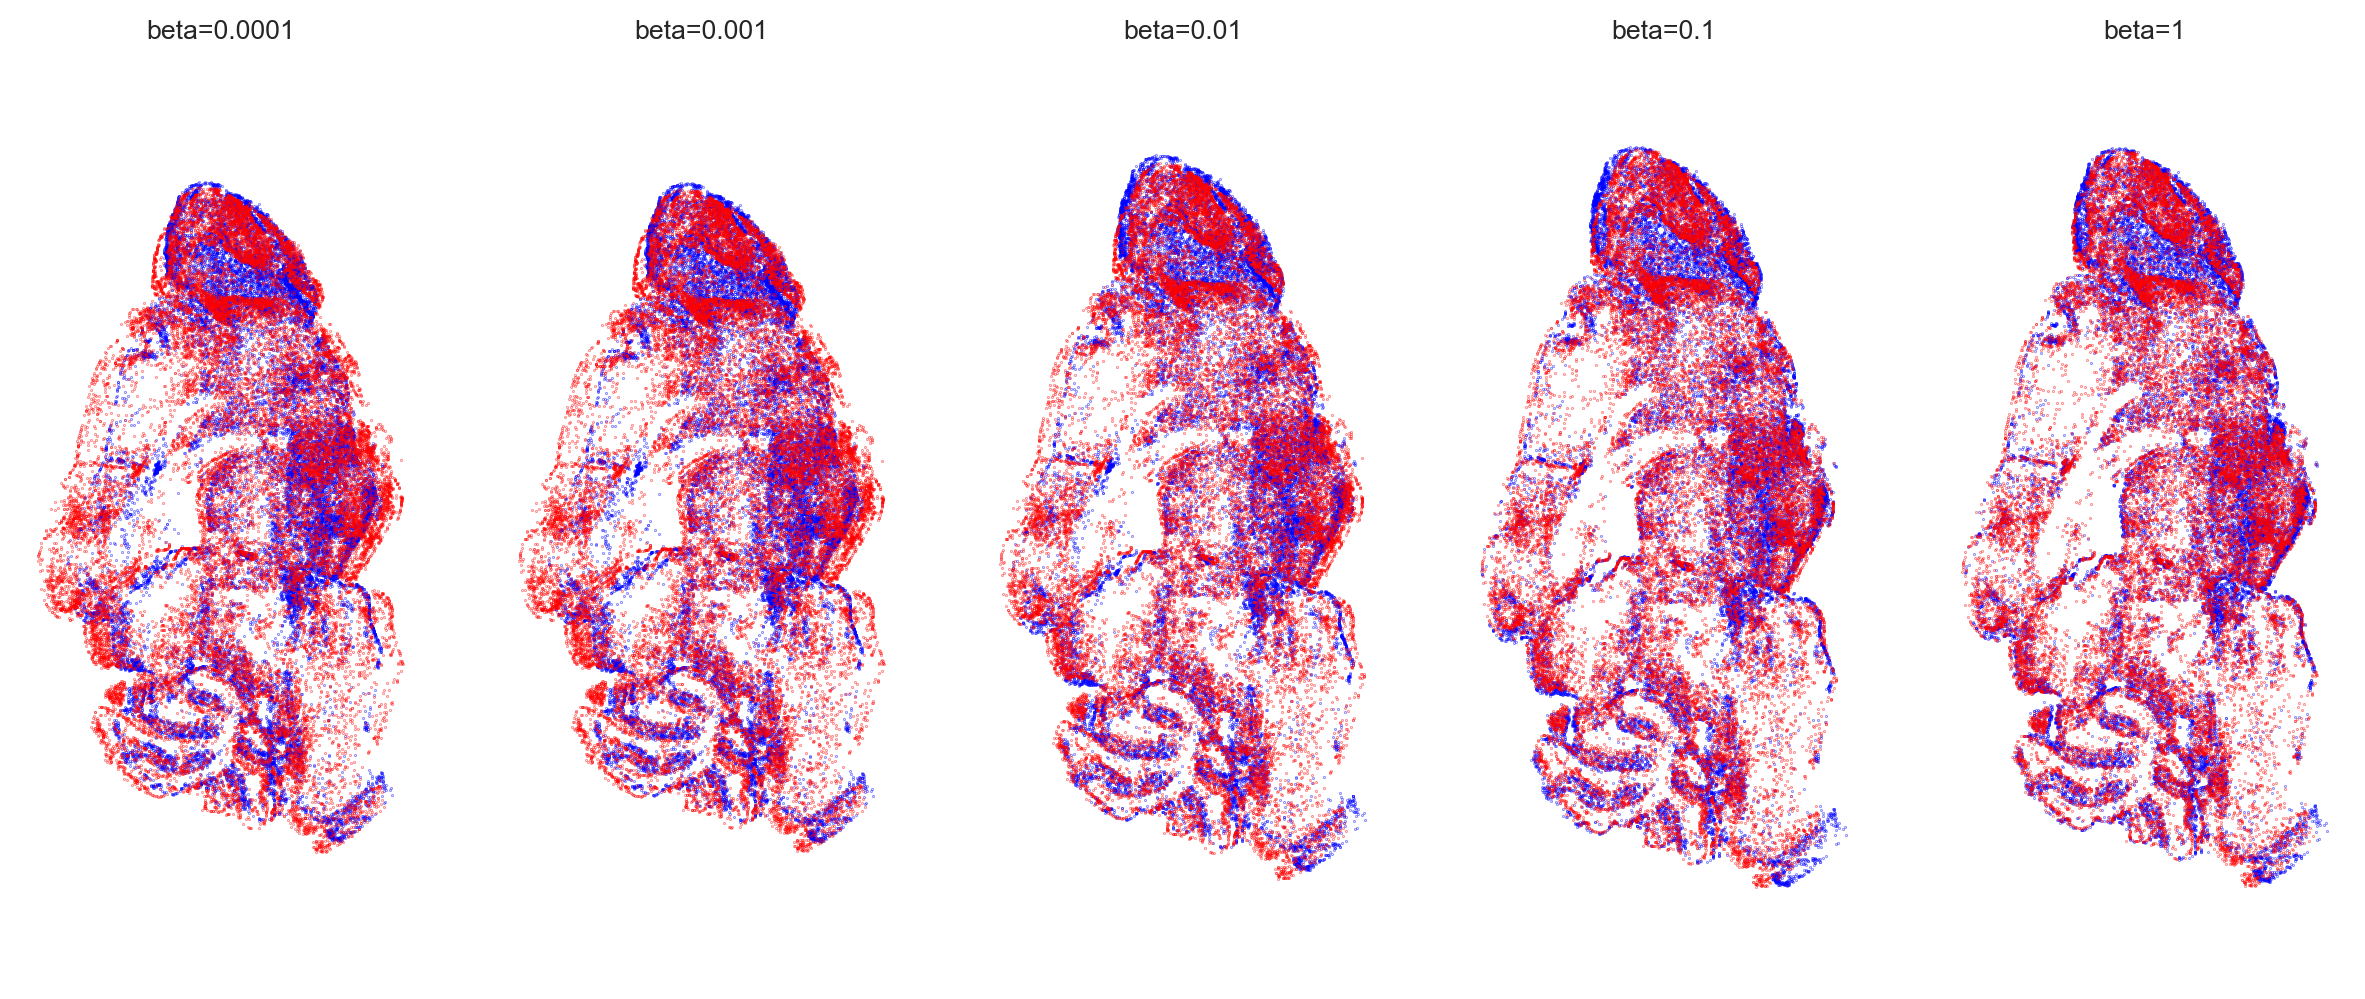

In [57]:
lambdaVF = 1e3
fig, axs = plt.subplots(1, 5, figsize=(15,6))
point_size=0.02
for i, beta in enumerate(beta_list):
    key_added = f"align_spatial_{beta}_{lambdaVF}_nonrigid"
    slice1_spatial = aligned_slices[0].obsm['spatial']
    slice2_spaital = aligned_slices[1].obsm[key_added]
    axs[i].scatter(*slice1_spatial.T, s=point_size, c='blue', label='slice1', edgecolor=None)
    axs[i].scatter(*slice2_spaital.T, s=point_size, c='red', label='slice2', edgecolor=None)
    axs[i].set_title(f"beta={beta}")
    axs[i].axis('equal')
    axs[i].axis('off')
plt.show()

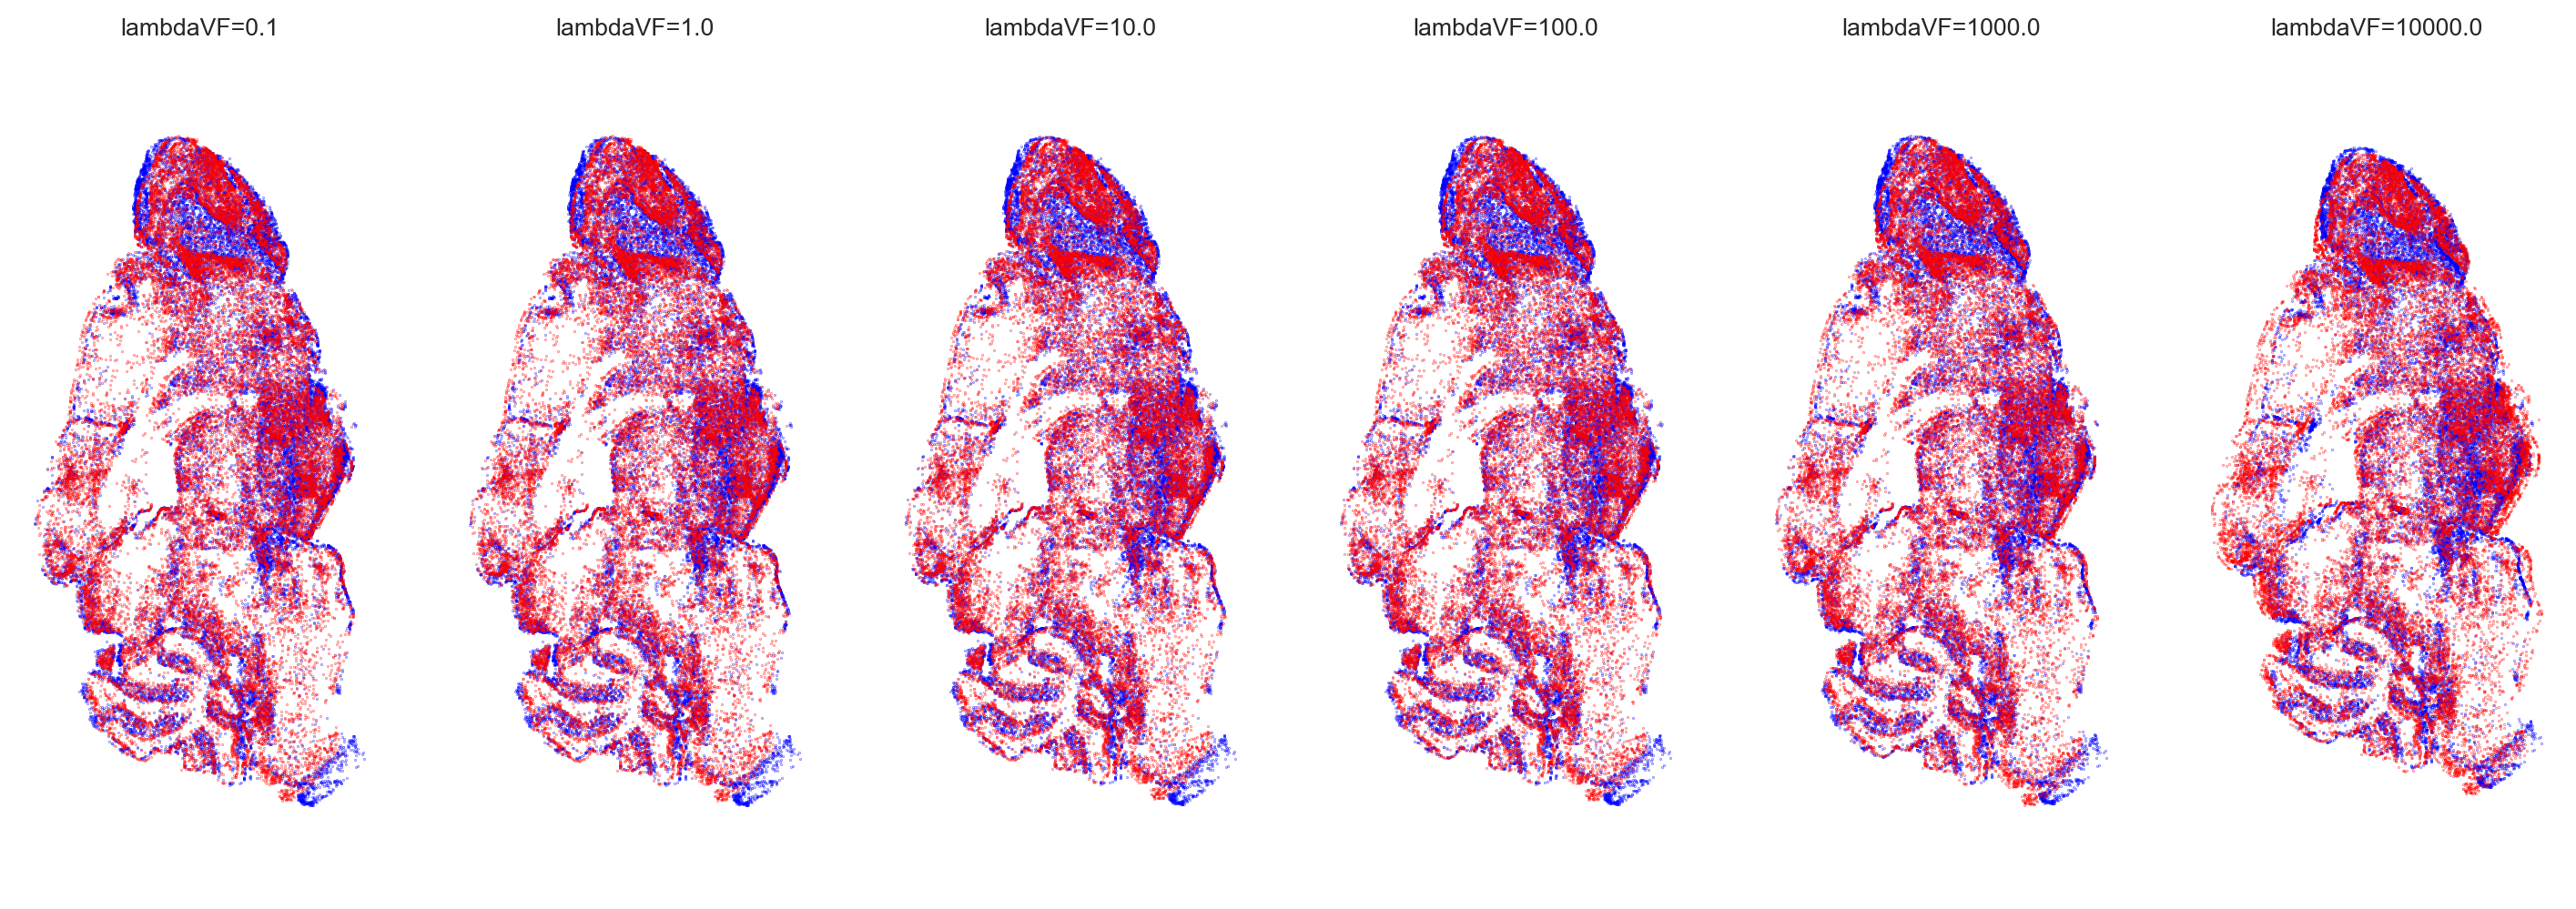

In [46]:
beta = 1e-1
fig, axs = plt.subplots(1, 6, figsize=(18, 6))
point_size=0.02
for i, lambdaVF in enumerate(lambdaVF_list):
    key_added = f"align_spatial_{beta}_{lambdaVF}_nonrigid"
    slice1_spatial = aligned_slices[0].obsm['spatial']
    slice2_spaital = aligned_slices[1].obsm[key_added]
    axs[i].scatter(*slice1_spatial.T, s=point_size, c='blue', label='slice1', edgecolor=None)
    axs[i].scatter(*slice2_spaital.T, s=point_size, c='red', label='slice2', edgecolor=None)
    axs[i].set_title(f"lambdaVF={lambdaVF}")
    axs[i].axis('equal')
    axs[i].axis('off')
plt.show()

To quantify the alignment result, we compute the maes and draw the heatmap

In [17]:
maes = np.zeros((len(beta_list), len(lambdaVF_list)))
for i, beta in enumerate(beta_list):
    for j, lambdaVF in enumerate(lambdaVF_list):
        key_added = f"align_spatial_{beta}_{lambdaVF}"
        maes[i, j], _ = MAE(aligned_slices[1].obsm['spatial'], aligned_slices[1].obsm[f'{key_added}_nonrigid'])

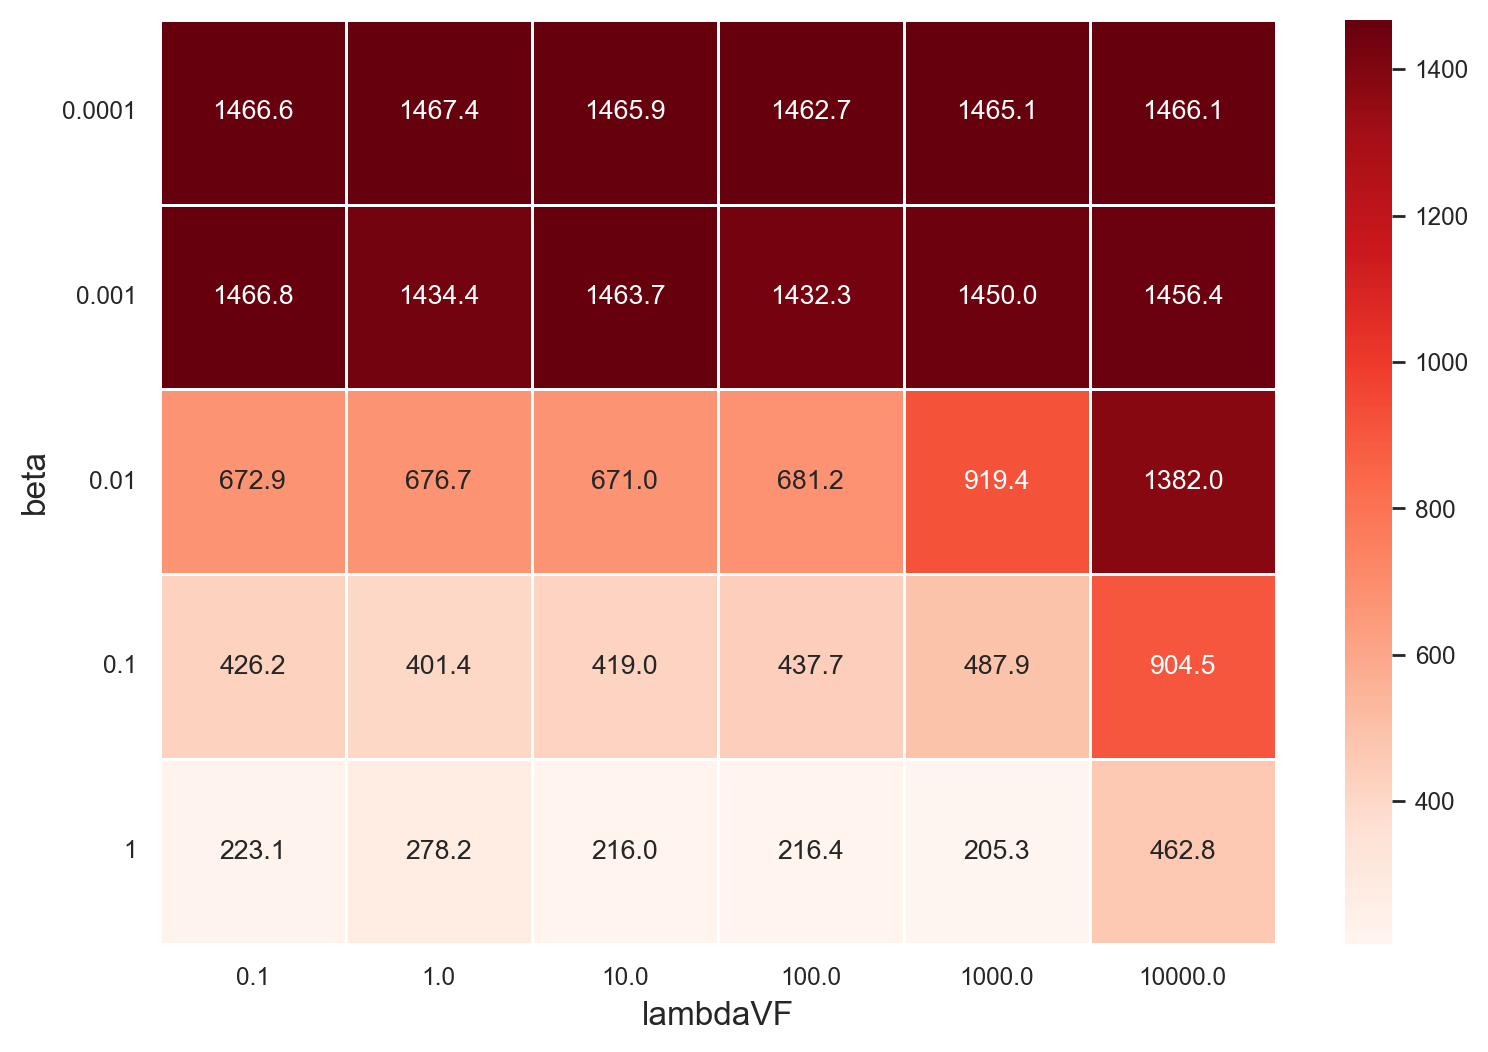

In [31]:
import seaborn as sns
sns.set_theme(
    context="paper",
    style="white",
    font="Arial",
    font_scale=1,
    rc={
        "font.family": ["sans-serif"],
        "font.sans-serif": ["Arial", "sans-serif", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"],
    },
)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(maes, annot=True, fmt=".1f", linewidths=.5, ax=ax,cmap='Reds')
ax.set_xticklabels(lambdaVF_list)
ax.set_yticklabels(beta_list, rotation=0)
ax.set_xlabel('lambdaVF', fontdict={'size': 12})
ax.set_ylabel('beta', fontdict={'size': 12})
plt.show()

## Conclusion

Spateo nonrigid alignment is easy to use. 

<div class="alert alert-warning">
<strong>Warning:</strong>
    
Although nonrigid alignment is better for aligning local structures, it may not always be the best choice in 3D reconstruction. Consecutive slices are inherently different, and it's often unclear whether the deformation in a slice is due to distortions during slicing or reflects the original structure. To help with this, we offer a tutorial on how to determine when to use nonrigid alignment in 3D reconstruction.

When to use nonrigid in 3D reconstruction: [3D reconstruction with pairwise alignment](./3D%20reconstruction%20with%20pairwise%20alignment.ipynb)
    
</div>